<a href="https://colab.research.google.com/github/antonioenas/Denoising_HPatches_for_Descriptor_Learning/blob/master/2_baseline_descriptor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2) Baseline descriptor - Deep learning coursework, Imperial College London
**Antonio Enas, 01070859, AE1115**


---

In this notebook, the user can generate, train and save the baseline descriptor model.
The notebook can be used to train both onto clean patches and denoised patches, prior loading of a denoiser model.


To use denoised patches, load a Keras .h5 model in `denoiser_model` and set `use_clean_bool = True`.


Structure:
1. Environment set up
2. Define model
3. Training up to 1 epoch
4. Full training

In [0]:
use_clean_bool = True
denoiser_model = None

# 1. Environment set up
This section ensures all libraries and dataset are correctly imported.

If data is already mounted select:
              `import_data = False`

In [0]:
import_data = False

### Optional GPU check

In [0]:
# Taken from
# https://stackoverflow.com/questions/48750199/google-colaboratory-misleading-information-about-its-gpu-only-5-ram-available
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# Colab only provides one GPU and it is not always guaranteed
gpu = GPUs[0]
def printm():
  process = psutil.Process(os.getpid())
  print("RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
  print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

In [0]:
import GPUtil as GPU
GPUs = GPU.getGPUs()

GPUs

[]

### Cloning the repository and downloading the data

In [0]:
if import_data == False:
  # Change directory
  %cd /content/keras_triplet_descriptor
else:
  # Clone repo
  !git clone https://github.com/MatchLab-Imperial/keras_triplet_descriptor
  %cd /content/keras_triplet_descriptor
  # Download data
  !wget -O hpatches_data.zip https://imperialcollegelondon.box.com/shared/static/ah40eq7cxpwq4a6l4f62efzdyt8rm3ha.zip
  # Extract data
  !unzip -q ./hpatches_data.zip
  !rm ./hpatches_data.zip


### Importing Necessary Modules

In [0]:
!pip install -U seaborn

import sys
import json
import os
import glob
import time
import tensorflow as tf
import numpy as np
import cv2
import random

import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda, Reshape
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization 
from keras.layers import Input, UpSampling2D, concatenate  

from read_data import HPatches, DataGeneratorDesc, hpatches_sequence_folder, DenoiseHPatches, tps
from utils import generate_desc_csv, plot_denoise, plot_triplet

# Plotting tools
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-white')
plt.rcParams["patch.force_edgecolor"] = True

# To download files
from google.colab import files

from sklearn.decomposition import PCA
import pandas as pd

In [0]:
random.seed(1234)
np.random.seed(1234)
tf.set_random_seed(1234)

hpatches_dir = './hpatches'
splits_path = './splits.json'

splits_json = json.load(open(splits_path, 'rb'))
split = splits_json['a']

train_fnames = split['train']
test_fnames = split['test']

seqs = glob.glob(hpatches_dir+'/*')
seqs = [os.path.abspath(p) for p in seqs]   
seqs_train = list(filter(lambda x: x.split('/')[-1] in train_fnames, seqs)) 
seqs_test = list(filter(lambda x: x.split('/')[-1] in split['test'], seqs)) 


# 2. Define model
In this section the baseline mode, generator data and compiler are defined.

The baseline mode consists of a L2Net trained with standard triplet loss.

In [0]:
def get_descriptor_model(shape):
  
  '''Architecture copies HardNet architecture'''
  
  init_weights = keras.initializers.he_normal()
  
  descriptor_model = Sequential()
  descriptor_model.add(Conv2D(32, 3, padding='same', input_shape=shape, use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('relu'))

  descriptor_model.add(Conv2D(32, 3, padding='same', use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('relu'))

  descriptor_model.add(Conv2D(64, 3, padding='same', strides=2, use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('relu'))

  descriptor_model.add(Conv2D(64, 3, padding='same', use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('relu'))

  descriptor_model.add(Conv2D(128, 3, padding='same', strides=2,  use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('relu'))

  descriptor_model.add(Conv2D(128, 3, padding='same', use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('relu'))
  descriptor_model.add(Dropout(0.3))

  descriptor_model.add(Conv2D(128, 8, padding='valid', use_bias = True, kernel_initializer=init_weights))
  
  # Final descriptor reshape
  descriptor_model.add(Reshape((128,)))
  
  return descriptor_model

In [0]:
def triplet_loss(x):
  
  output_dim = 128
  a, p, n = x
  _alpha = 1.0
  positive_distance = K.mean(K.square(a - p), axis=-1)
  negative_distance = K.mean(K.square(a - n), axis=-1)
  
  return K.expand_dims(K.maximum(0.0, positive_distance - negative_distance + _alpha), axis = 1)

Build the siamese network and choose optimiser.

In [0]:
optimiser_name = 'adam'

In [0]:
shape = (32, 32, 1)
xa = Input(shape=shape, name='a')
xp = Input(shape=shape, name='p')
xn = Input(shape=shape, name='n')
descriptor_model = get_descriptor_model(shape)
ea = descriptor_model(xa)
ep = descriptor_model(xp)
en = descriptor_model(xn)

loss = Lambda(triplet_loss)([ea, ep, en])

descriptor_model_trip = Model(inputs=[xa, xp, xn], outputs=loss)

descriptor_model_trip.compile(loss='mean_absolute_error', optimizer=optimiser_name, metrics = ['accuracy'])

Print the model summary.

In [0]:
descriptor_model_trip.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
a (InputLayer)                  (None, 32, 32, 1)    0                                            
__________________________________________________________________________________________________
p (InputLayer)                  (None, 32, 32, 1)    0                                            
__________________________________________________________________________________________________
n (InputLayer)                  (None, 32, 32, 1)    0                                            
__________________________________________________________________________________________________
sequential_4 (Sequential)       (None, 128)          1336928     a[0][0]                          
                                                                 p[0][0]                          
          

Create the training and validation generators (with or without clean patches).

In [0]:
### Descriptor loading and training
# Loading images
hPatches = HPatches(train_fnames=train_fnames, test_fnames=test_fnames,
                    denoise_model=denoiser_model, use_clean=use_clean_bool)

# Creating training generator
training_generator = DataGeneratorDesc(*hPatches.read_image_file(hpatches_dir, train=1), num_triplets=100000)
# Creating validation generator
val_generator = DataGeneratorDesc(*hPatches.read_image_file(hpatches_dir, train=0), num_triplets=10000)


Using denoised patches
100%|██████████| 116/116 [00:36<00:00,  3.16it/s]
Denoising patches...
100%|██████████| 15589/15589 [04:15<00:00, 60.92it/s]


100%|██████████| 100000/100000 [00:01<00:00, 71001.65it/s]


Using denoised patches
100%|██████████| 116/116 [00:20<00:00,  5.67it/s]
Denoising patches...
100%|██████████| 9525/9525 [02:36<00:00, 60.99it/s]


100%|██████████| 10000/10000 [00:00<00:00, 25435.58it/s]


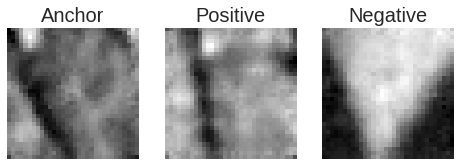

In [0]:
plot_triplet(training_generator)

# 3. One epoch training

In [0]:
descriptor_history = descriptor_model_trip.fit_generator(
    generator=training_generator,
    epochs=1,
    verbose=1,
    validation_data=val_generator)


# Save model
descriptor_model.save('bs_descriptor_1e.h5') 
# Uploads files to external hosting
!curl -F "file=@bs_descriptor_1e.h5" https://file.io

Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.2167

 95%|█████████▌| 95050/100000 [00:03<00:00, 37034.79it/s]

2000/2000 [==============================] - 163s 81ms/step - loss: 0.2166 - val_loss: 0.2888


100%|██████████| 10000/10000 [00:00<00:00, 22997.55it/s]


{"success":true,"key":"uXi7bl","link":"https://file.io/uXi7bl","expiry":"14 days"}

# 4. Full training

Train until 20 epochs are reached.

In [0]:
descriptor_history = descriptor_model_trip.fit_generator(generator = training_generator,
                                                         epochs = 20,
                                                         verbose = 1,
                                                         validation_data = val_generator)

Text(0.5,0,'Epoch')

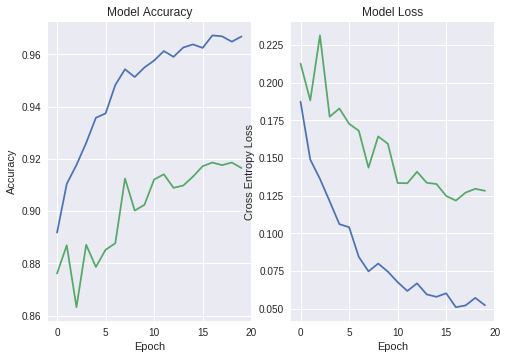

In [0]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1,2)
axes[0].plot(descriptor_history.history['acc'])
axes[0].plot(descriptor_history.history['val_acc'])
axes[0].set_title('Model Accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epoch')

fig.subplots_adjust(hspace=0.5)

axes[1].plot(descriptor_history.history['loss'])
axes[1].plot(descriptor_history.history['val_loss'])
axes[1].set_title('Model Loss')
axes[1].set_ylabel('Cross Entropy Loss')
axes[1].set_xlabel('Epoch')

Save fully trained model.

In [0]:
# Save model
descriptor_model.save('bs_descriptor_20e.h5') 
# Uploads files to external hosting
!curl -F "file=@bs_descriptor_20e.h5" https://file.io